In [1]:
import os
import glob

from tqdm import tqdm

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.models import resnet34, resnet18

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import torch.optim as optim
# from torchsummaryX import summary

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [28]:
nn.Linear(1024,2).in_features

1024

In [2]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [3]:
class Net(nn.Module):
    def __init__(self,backbone=resnet34,pretrained=True,num_classes=2):
        super().__init__()
        self.model = backbone(pretrained=pretrained)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features,num_classes)
    def forward(self,x):
        return self.model(x)
        
        

class CatDogDataset(Dataset):
    def __init__(self, filepath, train=False,test_size=0.1, seed=12345, transform=None):
#         self.imges_filepaths = glob.glob(os.path.join(filepath,'/**/*.jpg'))
        self.classes = next(iter(os.walk(filepath)))[1]
        imgs, labels = [], []
        for i,cl in enumerate(self.classes):
            findpath = os.path.join(filepath,f'{cl}/','*.jpg')
            current_imgs = glob.glob(findpath)
            imgs += current_imgs
            labels += [i for _ in current_imgs]
        img_train, img_test, label_train, label_test = train_test_split(imgs, labels, test_size=test_size,
                                                                        random_state=seed)
        if train:
            self.imgs = img_train
            self.labels = label_train
        else:
            self.imgs = img_test
            self.labels = label_test
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        image_filepath = self.imgs[idx]
        label = self.labels[idx]
        
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [23]:
# Setting variables

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

train_batch_size = 128
val_batch_size = 128
workers = 12
rate_learning = 1e-5

In [16]:
net = Net()
# net = Net(in_channels=3, num_classes=10)
net.to(device)

Net(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [17]:
# dataloader

seed = 123451

transform_train = A.Compose(
    [
        A.SmallestMaxSize(max_size=256),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=224, width=224),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

transform_val = A.Compose(
    [
        A.SmallestMaxSize(max_size=224),
        A.CenterCrop(height=224, width=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)


root = './data/catdog/train'
trainset = CatDogDataset(root,train=True,test_size=0.1, seed=seed, transform = transform_train)
valset = CatDogDataset(root,train=False,test_size=0.1, seed=seed, transform = transform_val)


trainloader = DataLoader(trainset, batch_size=train_batch_size,
                         shuffle=True, num_workers=workers)
valloader = DataLoader(valset, batch_size=val_batch_size,
                        shuffle=False, num_workers=workers)

classes = trainset.classes
print(classes)

['dog', 'cat']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    0     0     1     1


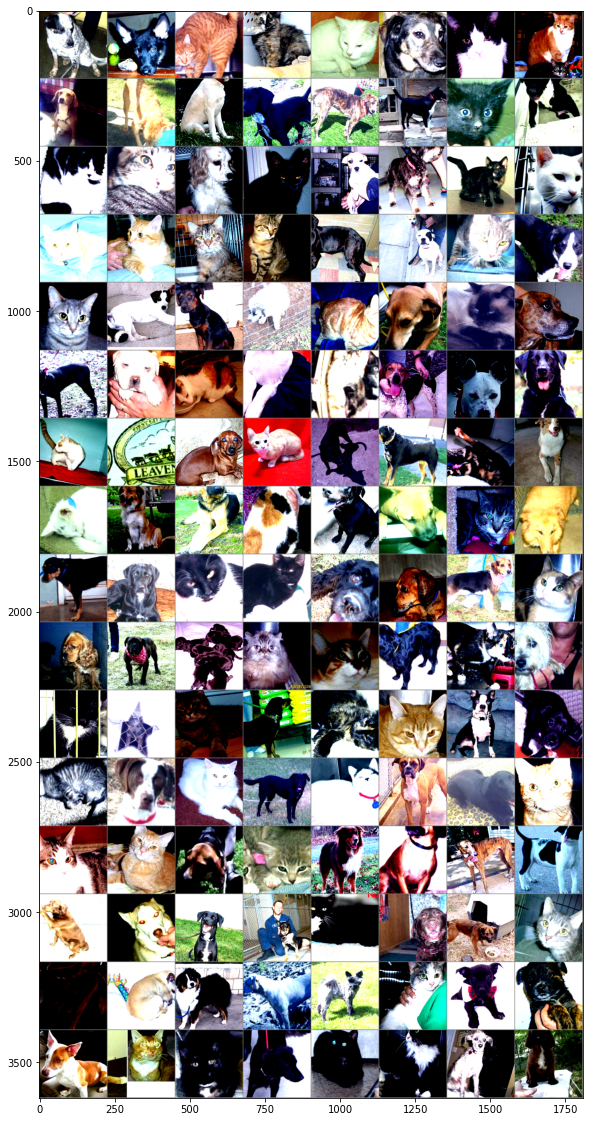

In [26]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
plt.figure(figsize=(20,20))
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(4)))

In [19]:
# Set optimizer

# optimizer = optim.SGD(net.parameters(), lr=rate_learning, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=rate_learning)
criterion = nn.CrossEntropyLoss()

In [24]:
def train(total_epoch):
    net.train()
    for epoch in range(total_epoch):
        with tqdm(trainloader, unit='batch')as tepoch:
            tepoch.set_description(f'Epoch [{epoch+1}/{total_epoch}] ')
            running_loss = 0.0
            running_accuracy = 0.0
            running_batchsize = 0
            for inputs,labels in tepoch:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad() #zero grad 안하면 grad 를 계속 가지고 있는다.

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
                running_batchsize += inputs.cpu().detach().shape[0]
                running_accuracy += (predictions == labels).sum().item()
                running_loss += loss.item()
                tepoch.set_postfix(loss=running_loss/running_batchsize, accuracy=running_accuracy/running_batchsize)
        test()


def test():
    net.eval()
    with tqdm(valloader, unit='batch')as tepoch:
        tepoch.set_description(f'Validation ')
        running_loss = 0.0
        running_accuracy = 0.0
        running_batchsize = 0
        class_correct = {k:0 for k in classes}
        class_total = {k:0 for k in classes}
        
        for inputs,labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = net(inputs)
            loss = criterion(outputs,labels)
            predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
            running_batchsize += inputs.cpu().detach().shape[0]
            running_accuracy += (predictions == labels).sum().item()
            running_loss += loss.item()
            
            tepoch.set_postfix(loss=running_loss/running_batchsize, accuracy=running_accuracy/running_batchsize)
            
            for idx,name in enumerate(classes):
                label_idx = (labels == idx)
                if label_idx.sum().item() == 0:
                    continue
                class_correct[name] += labels[label_idx].eq(
                    torch.argmax(outputs[label_idx], 1)).sum().item()
                class_total[name] += labels[label_idx].size(0)
    for name in classes:
        print(f'Accuracy of {name}s : {100.*class_correct[name]/class_total[name]:.2f}%')


#         print(f'Accuracy : {(100.*correct/total):.3f}')
# #         classes = ('plane', 'car', 'bird', 'cat', 'deer', 'doge', 'frog', 'horse', 'ship', 'truck')
#         for i in range(10):
#             print(f'Accuracy of {classes[i]}s : {100.*class_correct[i]/class_total[i]:.2f}%')

In [25]:
train(10)

Epoch [2/10] :   0%|          | 0/176 [00:00<?, ?batch/s]

Accuracy of dogs : 99.60%
Accuracy of cats : 98.96%


Epoch [3/10] :   0%|          | 0/176 [00:00<?, ?batch/s]

Accuracy of dogs : 97.61%
Accuracy of cats : 99.52%


Epoch [4/10] :   0%|          | 0/176 [00:00<?, ?batch/s]

Accuracy of dogs : 98.96%
Accuracy of cats : 98.96%


Epoch [5/10] :   0%|          | 0/176 [00:00<?, ?batch/s]

Accuracy of dogs : 99.52%
Accuracy of cats : 98.55%


Epoch [6/10] :   0%|          | 0/176 [00:00<?, ?batch/s]

Accuracy of dogs : 98.88%
Accuracy of cats : 99.36%


Epoch [7/10] :   0%|          | 0/176 [00:00<?, ?batch/s]

Accuracy of dogs : 99.12%
Accuracy of cats : 99.44%


Epoch [8/10] :   0%|          | 0/176 [00:00<?, ?batch/s]

Accuracy of dogs : 99.76%
Accuracy of cats : 97.27%


Epoch [10/10] :   0%|          | 0/176 [00:00<?, ?batch/s]

Accuracy of dogs : 99.76%
Accuracy of cats : 98.47%


Validation : 100%|██████████| 20/20 [00:03<00:00,  5.13batch/s, accuracy=0.987, loss=0.000479]

Accuracy of dogs : 99.68%
Accuracy of cats : 97.67%


In [ ]:
#해볼일
# focal loss
# gradcam
# scheduler -> Cosine LR 로 해서 저장하는 procedure 까지 구현해보자.
# plot 그리기? 꺠끗하게.
# 저장 procedure
